In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.colors
import seaborn as sns
from sklearn.decomposition import FastICA, PCA
from scipy.stats import gaussian_kde
from rdkit import Chem
from rdkit.Chem import MACCSkeys
import pickle
import seaborn as sns

from Imitate import Imitate
from Mimic import *
from Multilabel import *

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

# Colors for plots

In [2]:
COLORS = {'SOIL': '#004488',
         'BBD': '#882255',
         'tr': '#BBBBBB',
         'imi': '#DDAA33',
         'bias': '#BB5566',
         'val': '#000000'}
COLNAMES = {'SOIL': 'blue', 'BBD': 'wine', 'imi': 'yellow'}
CMAPS = {'imi': matplotlib.colors.LinearSegmentedColormap.from_list("", [COLORS['imi'], 'white'], N=256),
        'SOIL': matplotlib.colors.LinearSegmentedColormap.from_list("", [COLORS['SOIL'], 'white'], N=256),
        'BBD': matplotlib.colors.LinearSegmentedColormap.from_list("", [COLORS['BBD'], 'white'], N=256),
        'SOIL_bi': matplotlib.colors.LinearSegmentedColormap.from_list("", ['#88CCEE', COLORS['SOIL'], '#000000'], N=256),
        'BBD_bi': matplotlib.colors.LinearSegmentedColormap.from_list("", ['#EE99AA', COLORS['BBD'], '#000000'], N=256)}

# Load Data

In [3]:
DF_SOIL = pd.read_csv('Data/SOIL_all.csv', header=0, index_col=0)
DF_BBD = pd.read_csv('Data/BBD_all.csv', header=0, index_col=0)
DF_AGRO = pd.read_csv('Data/AGRO_all.csv', header=0, index_col=0)

In [4]:
# load PCA models
pca_soil = pickle.load(open('Data\\PCA\\PCA_SOIL_model.pickle', 'rb'))
pca_bbd = pickle.load(open('Data\\PCA\\PCA_BBD_model.pickle', 'rb'))
pca_pubchem = pickle.load(open('Data\\PCA\\PCA_PubChem_model.pickle', 'rb'))

C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator PCA from version 1.0.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator IncrementalPCA from version 1.0.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
def get_maccs(compound):
    try:
        mol = Chem.MolFromSmiles(compound)
        return np.frombuffer(MACCSkeys.GenMACCSKeys(mol).ToBitString().encode(), 'u1') - ord('0')
    except:
        return np.NaN
    
soil_maccs = [get_maccs(c) for c in DF_SOIL.SMILES]
bbd_maccs = [get_maccs(c) for c in DF_BBD.SMILES]
agro_maccs = [get_maccs(c) for c in DF_AGRO.smiles]

In [6]:
# remove compounds for which we can't calculate MACCS
DF_AGRO['canCalcMACCS'] = [a is not np.nan for a in agro_maccs]
DF_AGRO = DF_AGRO.loc[DF_AGRO.canCalcMACCS, :]
agro_maccs = np.array([x for x in agro_maccs if x is not np.nan])

In [7]:
soil_maccs_root = np.array([get_maccs(c) for c in DF_SOIL[DF_SOIL.isRootCompound].SMILES])
bbd_maccs_root = np.array([get_maccs(c) for c in DF_BBD[DF_BBD.isRootCompound].SMILES])
soil_years_root = np.array(DF_SOIL[DF_SOIL.isRootCompound].year)
bbd_years_root = np.array(DF_BBD[DF_BBD.isRootCompound].year)

# Where is the bias (SOIL/BBD PCA space)?

In [40]:
def plot_vs_gt(data, pca, xedges, yedges, H_gt, whichdata='', ax=None, imi=True, ylabel=True):
    sns.set_style("ticks")
    plt.rc('font', family='serif')
    d = pca.transform(data)[:,:2] # use 2 PCs
    if imi:
        mids = []
        for r, row in enumerate(H):
            for c, col in enumerate(row):
                if H[r, c] > 0.0001:
                    mids.append([(xedges[c] + xedges[c+1])/2, (yedges[r] + yedges[r+1])/2])
        ica = FastICA(n_components = 2, random_state=2210, whiten='arbitrary-variance')
        ica.fit(d)
        mids = ica.transform(np.array(mids))
        range_gt = [[mids[:,0].min(), mids[:,0].max()], [mids[:,1].min(), mids[:,1].max()]]
        grids, _, fitted, fill_up, num_fill_up, _, _, _ = Imitate(ica.transform(d), bounds=range_gt, strength=1000)
        fill = max(num_fill_up)
        points = np.empty((1000, 0))
        for i in range(len(num_fill_up)):
            p = fitted[i] / np.sum(fitted[i]) * (fill - num_fill_up[i])  +  fill_up[i]
            coords = np.random.choice((np.array(grids[i][:-1])+np.array(grids[i][1:]))/2, size=1000, p=p/p.sum())
            points = np.concatenate((points, coords.reshape(1000, 1)), axis=1)
        points = ica.inverse_transform(points)

    if ax is None:
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot()
    ax.pcolormesh(xedges, yedges, H_gt.T, cmap='gist_gray')
    ax.set_xlim([min(xedges), max(xedges)])
    ax.set_ylim([min(yedges), max(yedges)])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(whichdata+' First PC')
    if ylabel: ax.set_ylabel(whichdata+' Second PC')
    ax = sns.kdeplot(x=d[:,0], y=d[:,1], cut=0.5, thresh=0.2, cmap=CMAPS[whichdata], levels=10, ax=ax)#, fill=True)
#     mult = len(points) / len(d)
#     cmax = 0.07737 if whichdata=='SOIL' else 0.1591
    if imi:
        ax = sns.kdeplot(x=points[:,0], y=points[:,1], cmap=CMAPS['imi'], cut=0.5, thresh=0.2, 
                         ax=ax)#, levels=int(10*mult), vmin=0, vmax=cmax/mult)
        ax.set_title(whichdata+' ('+COLNAMES[whichdata]+')\nvs. Bias ('+COLNAMES['imi']+') vs. PubChem (gray)')
    else:
        ax.set_title(whichdata+' ('+COLNAMES[whichdata]+') vs. PubChem (gray)')
    if ax is None:
        return fig

In [41]:
# plot development of root compounds over the years
def plot_vs_gt_root_dev(data, years, year_ranges, pca, xedges, yedges, H_gt, whichdata='', imi=True):
    sns.set_style("ticks")
    plt.rc('font', family='serif')
    
    if imi:
        fig, ax = plt.subplots(nrows=1, ncols=len(year_ranges), figsize=(9, 2.25*(75/62)), sharey=True)
        fig.subplots_adjust(top=0.62)
        fig.suptitle(whichdata+' ('+COLNAMES[whichdata]+')\nvs. Bias ('+COLNAMES['imi']+') vs. PubChem (gray)', y=0.98)
    else:
        fig, ax = plt.subplots(nrows=1, ncols=len(year_ranges), figsize=(9, 2.25*(75/68)), sharey=True)
        fig.subplots_adjust(top=0.68)
        fig.suptitle(whichdata+' ('+COLNAMES[whichdata]+') vs. PubChem (gray)', y=0.98)
    for i, y in enumerate(year_ranges):
        plot_vs_gt(data[years <= y], pca, xedges, yedges, H_gt, whichdata=whichdata, ax=ax[i], imi=imi, ylabel=i==0)
        ax[i].set_title(str(y)+'\n('+str(np.sum(years<=y))+' root compds)')
    return fig

#### SOIL

In [24]:
# read pre-calculated PCA results
df = pd.read_csv('Data\\PCA\\PCA_SOIL_minmax.txt', header=0, index_col='index')
low_soil, high_soil = df.loc['min'].to_numpy(), df.loc['max'].to_numpy()
range_hist_soil = df[['0', '1']].to_numpy().transpose()
hist_dict = np.load('Data\\PCA\\PCA_SOIL_hist_30.npy', allow_pickle=True)
H, xedges, yedges = hist_dict[()]['H'], hist_dict[()]['xedges'], hist_dict[()]['yedges']

<AxesSubplot:>

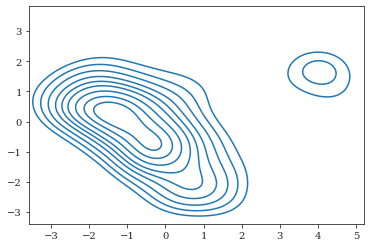

In [48]:
d = pca_soil.transform(soil_maccs_root)[:,:2]
sns.kdeplot(x=d[:,0], y=d[:,1], cut=0.5, thresh=0.2, levels=10)

In [49]:
DF_SOIL[DF_SOIL.isRootCompound].SMILES.reset_index().iloc[np.where(d[:,0] > 3)[0]].SMILES.to_csv('SOIL_littleBlob_compounds.txt', index=False)

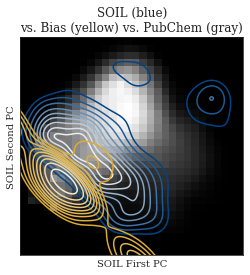

In [44]:
# plot
ax = plot_vs_gt(soil_maccs, pca_soil, xedges, yedges, H, whichdata='SOIL')
plt.savefig('Plots/SOILvsPubChem.pdf', bbox_inches='tight')
plt.show()

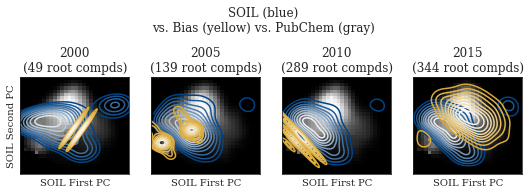

In [69]:
fig = plot_vs_gt_root_dev(soil_maccs_root, soil_years_root, [2000, 2005, 2010, 2015], pca_soil, 
                          xedges, yedges, H, whichdata='SOIL')
#plt.savefig('Plots/myplot.pdf', bbox_inches='tight')
plt.show()

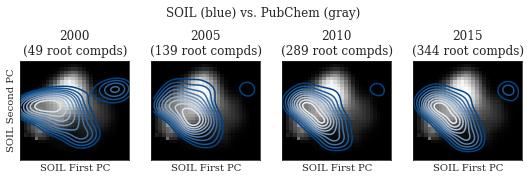

In [70]:
fig = plot_vs_gt_root_dev(soil_maccs_root, soil_years_root, [2000, 2005, 2010, 2015], pca_soil, 
                          xedges, yedges, H, whichdata='SOIL', imi=False)
plt.savefig('Plots/SOILvsPubChem_roots_nobias.pdf', bbox_inches='tight')
plt.show()

#### BBD

In [44]:
# read pre-calculated PCA results
df = pd.read_csv('Data\\PCA\\PCA_BBD_minmax.txt', header=0, index_col='index')
low_bbd, high_bbd = df.loc['min'].to_numpy(), df.loc['max'].to_numpy()
range_hist_bbd = df[['0', '1']].to_numpy().transpose()
hist_dict = np.load('Data\\PCA\\PCA_BBD_hist_30.npy', allow_pickle=True)
H, xedges, yedges = hist_dict[()]['H'], hist_dict[()]['xedges'], hist_dict[()]['yedges']

<AxesSubplot:>

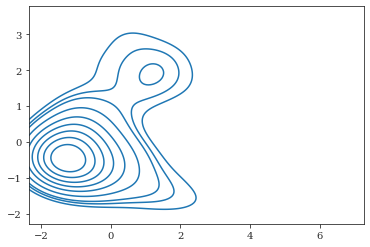

In [50]:
d = pca_bbd.transform(bbd_maccs_root)[:,:2]
sns.kdeplot(x=d[:,0], y=d[:,1], cut=0.5, thresh=0.2, levels=10)

In [51]:
DF_BBD[DF_BBD.isRootCompound].SMILES.reset_index().iloc[np.where(d[:,1] > 1.5)[0]].SMILES.to_csv('BBD_littleBlob_compounds.txt', index=False)

C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


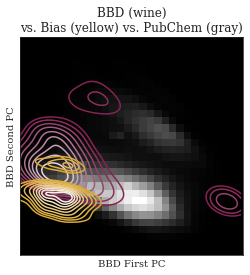

In [93]:
# plot
fig = plot_vs_gt(bbd_maccs, pca_bbd, xedges, yedges, H, whichdata='BBD')
plt.savefig('Plots/BBDvsPubChem.pdf', bbox_inches='tight')
plt.show()

C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


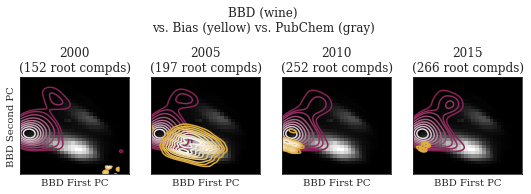

In [94]:
fig = plot_vs_gt_root_dev(bbd_maccs_root, bbd_years_root, [2000, 2005, 2010, 2015], pca_bbd, 
                          xedges, yedges, H, whichdata='BBD')
#plt.savefig('Plots/myplot.pdf', bbox_inches='tight')
plt.show()

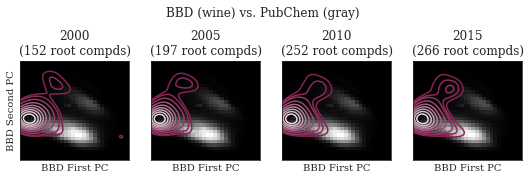

In [95]:
fig = plot_vs_gt_root_dev(bbd_maccs_root, bbd_years_root, [2000, 2005, 2010, 2015], pca_bbd, 
                          xedges, yedges, H, whichdata='BBD', imi=False)
plt.savefig('Plots/BBDvsPubChem_roots_nobias.pdf', bbox_inches='tight')
plt.show()

# PubChem PCA space

Instead of using the PCA space of the datasets themselves, we calculate the PubChem PCA space (we treat this as the ground-truth), so we can compare both datasets in the neutral space.

#### Plot both dataset in PubChem PCA space

In [96]:
def animate_both_ds_in_gt_space(data_soil, years_soil, data_bbd, years_bbd, xedges, yedges, H, pca, repeat=False):
    d1 = pca.transform(data_soil)
    d2 = pca.transform(data_bbd)
    years_uni = np.unique(np.sort(years_soil.append(years_bbd)))
    fig = plt.figure()
    ax = fig.add_subplot()
    s = 0  

    def plot(something):
        nonlocal ax, s
        ax.clear()
        ax.pcolormesh(xedges, yedges, H.T, cmap='gist_gray')
        ax.set_xlim([min(xedges), max(xedges)])
        ax.set_ylim([min(yedges), max(yedges)])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('First PC')
        ax.set_ylabel('Second PC')
        ax.set_title('SOIL ('+COLNAMES['SOIL']+') vs. BBD ('+COLNAMES['BBD']+') up to year '+str(years_uni[s]))
        x1,y1 = d1[years_soil <= years_uni[s]][:,0], d1[years_soil <= years_uni[s]][:,1]
        x2,y2 = d2[years_bbd <= years_uni[s]][:,0], d2[years_bbd <= years_uni[s]][:,1]
        ax = sns.kdeplot(x=x1, y=y1, cmap=plt.cm.get_cmap('Blues').reversed(), cut=0.5, thresh=0.2)
        ax = sns.kdeplot(x=x2, y=y2, cmap=plt.cm.get_cmap('Greens').reversed(), cut=0.5, thresh=0.2)
        s += 1

    ani = FuncAnimation(fig, plot, frames=len(years_uni), interval=500, repeat=repeat, blit=True)

    return ani

In [97]:
def plot_two_vs_gt(data1, data2, pca, xedges, yedges, H_gt, whichdata=['', ''], ax=None, ylabel=True):
    sns.set_style("ticks")
    plt.rc('font', family='serif')
    d1 = pca.transform(data1)[:,:2] # use 2 PCs
    d2 = pca.transform(data2)[:,:2] # use 2 PCs

    if ax is None:
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot()
    ax.pcolormesh(xedges, yedges, H_gt.T, cmap='gist_gray')
    ax.set_xlim([min(xedges), max(xedges)])
    ax.set_ylim([min(yedges), max(yedges)])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('PubChem First PC')
    if ylabel: ax.set_ylabel('PubChem Second PC')
    ax.set_title(whichdata[0]+' ('+COLNAMES[whichdata[0]]+') vs. '+whichdata[1]+' ('+COLNAMES[whichdata[1]]+') vs. PubChem (gray)')
    ax = sns.kdeplot(x=d1[:,0], y=d1[:,1], cmap=CMAPS[whichdata[0]], cut=0.5, thresh=0.2, ax=ax)
    ax = sns.kdeplot(x=d2[:,0], y=d2[:,1], cmap=CMAPS[whichdata[1]], cut=0.5, thresh=0.2, ax=ax)
    if ax is None:
        return fig

In [98]:
# plot development of root compounds over the years
def plot_two_vs_gt_root_dev(data1, data2, years1, years2, year_ranges, pca, xedges, yedges, H_gt, whichdata=['', '']):
    sns.set_style("ticks")
    plt.rc('font', family='serif')
    fig, ax = plt.subplots(nrows=1, ncols=len(year_ranges), figsize=(9, 2.25), sharey=True)
    fig.subplots_adjust(top=0.75)
    fig.suptitle(whichdata[0]+' ('+COLNAMES[whichdata[0]]+') vs. '+whichdata[1]+' ('+COLNAMES[whichdata[1]]+') vs. PubChem (gray)', y=0.98)
    for i, y in enumerate(year_ranges):
        plot_two_vs_gt(data1[years1 <= y], data2[years2 <= y], pca, xedges, yedges, H_gt, whichdata=whichdata, ax=ax[i],
                      ylabel=i==0)
        ax[i].set_title(str(y))
    return fig

In [105]:
hist_dict = np.load('Data\\PCA\\PCA_PubChem_hist_30.npy', allow_pickle=True)
H, xedges, yedges = hist_dict[()]['H'], hist_dict[()]['xedges'], hist_dict[()]['yedges']

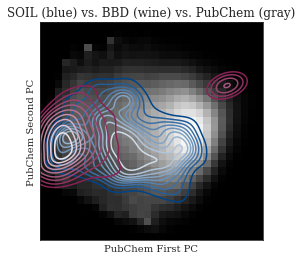

In [106]:
fig = plot_two_vs_gt(soil_maccs, bbd_maccs, pca_pubchem, xedges, yedges, H, whichdata=['SOIL', 'BBD'])
#plt.savefig('Plots/myplot.pdf', bbox_inches='tight')
plt.show()

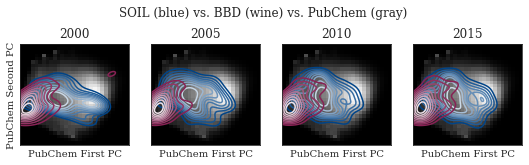

In [107]:
fig = plot_two_vs_gt_root_dev(soil_maccs_root, bbd_maccs_root, soil_years_root, bbd_years_root, [2000, 2005, 2010, 2015],
                              pca_pubchem, xedges, yedges, H, whichdata=['SOIL', 'BBD'])
plt.savefig('Plots/BBDandSOILvsPubChem_root_years.pdf', bbox_inches='tight')
plt.show()

# Quantify Growth

In [55]:
def get_indices_per_year(data, years, pca):
    d = pca.transform(data)
    ys = np.unique(years[years >= 1990])
    ys.sort()
    df = pd.DataFrame(columns=['Year', 'Distance to Center'])
    for y in ys:
        X = pca.transform(data[years <= y])[:, :2]  
        center = np.average(X, axis=0)
        dist_to_center = np.sqrt(np.sum((X - center)**2, axis=1))
        df = df.append(pd.DataFrame(np.transpose([[int(y)]*len(X), dist_to_center]), columns=df.columns))
    df = df.astype({'Distance to Center': 'float', 'Year': 'int'})
    return df

In [56]:
df_soil = get_indices_per_year(soil_maccs_root, soil_years_root, pca_pubchem)
df_bbd = get_indices_per_year(bbd_maccs_root, bbd_years_root, pca_pubchem)
df_soil['Dataset'] = 'SOIL'
df_bbd['Dataset'] = 'BBD'

In [80]:
def plot_indices_dev(df):
    sns.set_style("ticks")
    plt.rc('font', family='serif')
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5, 3.5), sharex=True)
    fig.subplots_adjust(hspace=0.4)
    ax[0] = sns.lineplot(x='Year', y='Distance to Center', data=df,
                        hue='Dataset', marker='o', 
                        palette=COLORS, ax=ax[0], legend=False)
    ax[0].set_title('Distance to Dataset Center')
    df2 = pd.DataFrame({'Size' : df.groupby( [ "Year", "Dataset"] ).size()}).reset_index()
    ax[1] = sns.lineplot(x='Year', y='Size', data=df2,
                        hue='Dataset', marker='o', 
                        palette=COLORS, ax=ax[1])
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1].set_title('Dataset Size')
    ax[1].tick_params(axis='x', rotation=315)
    #ax[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.3), ncol=2, frameon=False)
    ax[1].legend(loc='lower left', bbox_to_anchor=(1.01, 0), ncol=1, frameon=False)
    return fig

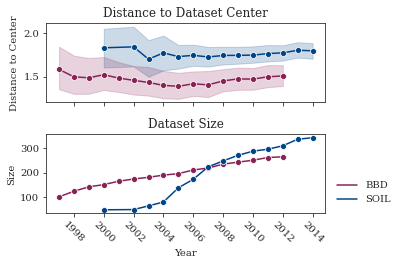

In [81]:
fig = plot_indices_dev(df_soil.append(df_bbd, ignore_index=True))
plt.savefig('Plots/BBDandSOIL_development.pdf', bbox_inches='tight')
plt.show()

# Use only agrochemical records as ground-truth

PubChem contains all compounds ever found. Maybe that's too broad? I am limiting to only compounds with an "agrochemical" flag since this is the domain SOIL and BBD operate in. Note that both datasets should still be a subset of the agrochemical data.

In [8]:
# PCA for the Agrochemical subset
pca_agro = PCA(n_components = 10, random_state=2210)
pca_agro.fit(agro_maccs)
agro_maccs_trf = pca_agro.transform(agro_maccs)
range_hist_agro = np.vstack((agro_maccs_trf.min(axis=0), agro_maccs_trf.max(axis=0))).transpose()
H, xedges, yedges = np.histogram2d(agro_maccs_trf[:,0], agro_maccs_trf[:,1], bins=30, range=range_hist_agro[:2])

In [9]:
def score_points(imi_data, imi_bounds, score_data_trf, pca, n_pca=5):
    d = pca.transform(imi_data)[:,:n_pca] # use 2 PCs
    ica = FastICA(n_components = n_pca, random_state=2210, whiten='arbitrary-variance')
    ica.fit(d)
    grids, vals, fitted, fill_up, _, _, _, _ = Imitate(ica.transform(d), bounds=imi_bounds[:n_pca], strength=1000)
    scores = mimic_score(ica.transform(score_data_trf[:,:n_pca]), grids, vals, fitted, fill_up)
    return scores

In [143]:
# scores_soil = score_points(soil_maccs, range_hist_agro, agro_maccs_trf, pca_agro)
# scores_soil_sort_idcs = np.argsort(scores_soil)
# DF_AGRO['scores_soil'] = scores_soil
# DF_AGRO['scores_soil_sort_idcs'] = scores_soil_sort_idcs
# scores_bbd = score_points(bbd_maccs, range_hist_agro, agro_maccs_trf, pca_agro)
# scores_bbd_sort_idcs = np.argsort(scores_bbd)
# DF_AGRO['scores_bbd'] = scores_bbd
# DF_AGRO['scores_bbd_sort_idcs'] = scores_bbd_sort_idcs

In [144]:
# note top 50 and top 20 scored compounds

# idcs = DF_AGRO.loc[DF_AGRO.isInSOIL==False].sort_values('scores_soil',ascending=False).head(50).index
# tmp = np.zeros(len(DF_AGRO))
# tmp[idcs] = 1
# DF_AGRO['SOIL_top50'] = tmp

# idcs = DF_AGRO.loc[DF_AGRO.isInBBD==False].sort_values('scores_bbd',ascending=False).head(50).index
# tmp = np.zeros(len(DF_AGRO))
# tmp[idcs] = 1
# DF_AGRO['BBD_top50'] = tmp

# idcs = DF_AGRO.loc[DF_AGRO.isInSOIL==False].sort_values('scores_soil',ascending=False).head(20).index
# tmp = np.zeros(len(DF_AGRO))
# tmp[idcs] = 1
# DF_AGRO['SOIL_top20'] = tmp

# idcs = DF_AGRO.loc[DF_AGRO.isInBBD==False].sort_values('scores_bbd',ascending=False).head(20).index
# tmp = np.zeros(len(DF_AGRO))
# tmp[idcs] = 1
# DF_AGRO['BBD_top20'] = tmp

In [10]:
USE_CATS = ['acaricide', 'attractant', 'biocide', 'fungicide', 'herbicide', 'insecticide', 
            'growth reg', 'transformation product', 'drug', 'food', 'health hazard', 'fire hazard']
USE_CATS_SHORT = ['acaricide', 'attractant', 'biocide', 'fungicide', 'herbicide', 'insecticide', 
                  'growth reg.', 'trafo prod.', 'drug', 'food', 'health hazard', 'fire hazard']

C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


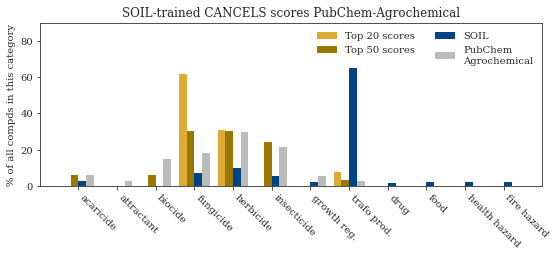

In [12]:
df_not_soil = DF_AGRO.loc[DF_AGRO.isInSOIL == False]
df_not_soil.rename(columns={'plant growth regulator':'growth reg'}, inplace=True)
df_not_soil_top20 = df_not_soil.loc[df_not_soil.SOIL_top20 > 0]
df_not_soil_top50 = df_not_soil.loc[df_not_soil.SOIL_top50 > 0]
avg_top20 = np.sum(df_not_soil_top20[USE_CATS[:-4]].to_numpy(), axis=0)
avg_top20 = avg_top20 / np.sum(avg_top20)
avg_top50 = np.sum(df_not_soil_top50[USE_CATS[:-4]].to_numpy(), axis=0)
avg_top50 = avg_top50 / np.sum(avg_top50)
avg_all = np.sum(df_not_soil[USE_CATS[:-4]].to_numpy(), axis=0)
avg_all = avg_all / np.sum(avg_all)
avg_soil = np.sum(DF_SOIL[USE_CATS], axis=0).to_numpy()
avg_soil = avg_soil / np.sum(avg_soil)

sns.set_style("ticks")
plt.rc('font', family='serif')
fig, ax = plt.subplots(figsize = (9, 3))
width = 0.2
x = np.arange(len(USE_CATS_SHORT))
ax.bar(x - 1.5*width, np.append(avg_top20, [0]*4)*100, width, label='Top 20 scores', color=COLORS['imi'], edgecolor = "none")
ax.bar(x - 0.5*width, np.append(avg_top50, [0]*4)*100, width, label='Top 50 scores', color='#997700', edgecolor = "none")
ax.bar(x + 0.5*width, avg_soil*100, width, label='SOIL', color=COLORS['SOIL'], edgecolor = "none")
ax.bar(x + 1.5*width, np.append(avg_all, [0]*4)*100, width, label='PubChem\nAgrochemical', color=COLORS['tr'], edgecolor = "none")
ax.set_ylabel('% of all compds in this category')
ax.set_title('SOIL-trained CANCELS scores PubChem-Agrochemical')
ax.set_xticks(x)
ax.set_xticklabels(USE_CATS_SHORT, rotation=315, ha='left')
ax.set_ylim([0, 90])
ax.legend(frameon=False, ncol=2, loc='upper right')
plt.savefig('Plots/SOIL_categories.pdf', bbox_inches='tight')
plt.show()

C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


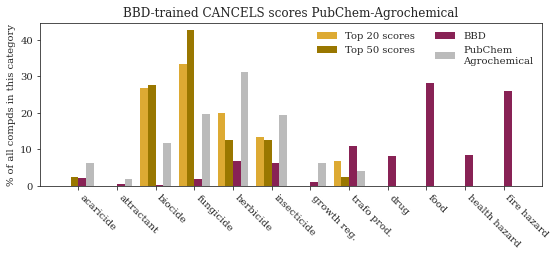

In [13]:
df_not_bbd = DF_AGRO.loc[DF_AGRO.isInBBD == False]
df_not_bbd.rename(columns={'plant growth regulator':'growth reg'}, inplace=True)
df_not_bbd_top20 = df_not_bbd.loc[df_not_bbd.BBD_top20 > 0]
df_not_bbd_top50 = df_not_bbd.loc[df_not_bbd.BBD_top50 > 0]
avg_top20 = np.sum(df_not_bbd_top20[USE_CATS[:-4]].to_numpy(), axis=0)
avg_top20 = avg_top20 / np.sum(avg_top20)
avg_top50 = np.sum(df_not_bbd_top50[USE_CATS[:-4]].to_numpy(), axis=0)
avg_top50 = avg_top50 / np.sum(avg_top50)
avg_all = np.sum(df_not_bbd[USE_CATS[:-4]].to_numpy(), axis=0)
avg_all = avg_all / np.sum(avg_all)
avg_bbd = np.sum(DF_BBD[USE_CATS], axis=0).to_numpy()
avg_bbd = avg_bbd / np.sum(avg_bbd)

sns.set_style("ticks")
plt.rc('font', family='serif')
fig, ax = plt.subplots(figsize = (9, 3))
width = 0.2
x = np.arange(len(USE_CATS_SHORT))
ax.bar(x - 1.5*width, np.append(avg_top20, [0]*4)*100, width, label='Top 20 scores', color=COLORS['imi'], edgecolor = "none")
ax.bar(x - 0.5*width, np.append(avg_top50, [0]*4)*100, width, label='Top 50 scores', color='#997700', edgecolor = "none")
ax.bar(x + 0.5*width, avg_bbd*100, width, label='BBD', color=COLORS['BBD'], edgecolor = "none")
ax.bar(x + 1.5*width, np.append(avg_all, [0]*4)*100, width, label='PubChem\nAgrochemical', color=COLORS['tr'], edgecolor = "none")
ax.set_ylabel('% of all compds in this category')
#ax.set_title('Imitate(BBD) --scores--> Agro')
ax.set_title('BBD-trained CANCELS scores PubChem-Agrochemical')
ax.set_xticks(x)
ax.set_xticklabels(USE_CATS_SHORT, rotation=315, ha='left')
ax.legend(frameon=False, ncol=2, loc='upper right')
plt.savefig('Plots/BBD_categories.pdf', bbox_inches='tight')
plt.show()

# Experiment: Do SOIL/BBD score themselves highly?

In [18]:
def split_high_low_density(data, percent_low):
    ica = FastICA(n_components = 2, random_state = 2210, whiten='arbitrary-variance')
    ica.fit(data)
    d = ica.transform(data)

    # split test into high and low density regions
    kde = gaussian_kde(d.T)
    kde_vals = kde.evaluate(d.T)
    threshold = np.percentile(kde_vals, q=percent_low) # min to max
    return kde_vals >= threshold

In [19]:
def score_high_low(data, percentile):
    is_high = split_high_low_density(data, percentile)
    pca_high = PCA(n_components = 10, random_state=2210)
    pca_high.fit(data[is_high])
    data_trf = pca_high.transform(data)
    range_high = np.vstack((data_trf[is_high].min(axis=0), data_trf[is_high].max(axis=0))).transpose()
    scores_low = score_points(data[is_high], range_high, data_trf[~is_high], pca_high)
    return scores_low, is_high

In [20]:
def compare_plot(data, percentile_list, which=''):
    for p in percentile_list:
        scores, _ = score_high_low(data, p)
        sns.kdeplot(scores, bw_method=0.5, label='p = '+str(p), c=CMAPS[which+'_bi'](int(p*256/100)))
    plt.legend(title="Removed and scored the p% of points with the lowest density.", 
               loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=len(percentile_list), frameon=False)
    plt.title(which+": CANCELS Scores for low density points")
    plt.xlabel('CANCELS Score')
    #plt.savefig('Plots/'+which+'_scores_low_density.pdf', bbox_inches='tight')
    plt.show()

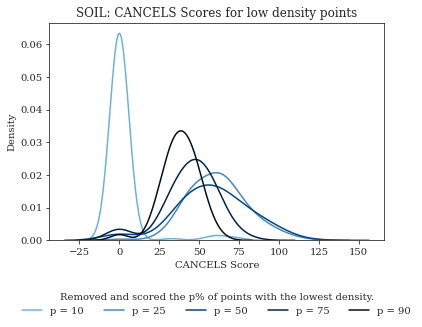

In [174]:
compare_plot(np.array(soil_maccs), [10, 25, 50, 75, 90], which='SOIL')

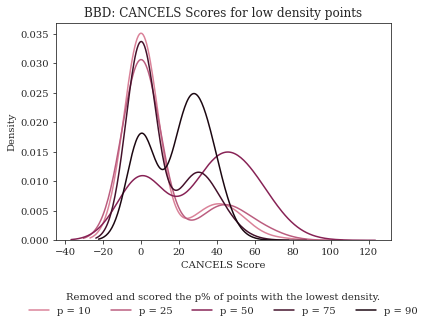

In [176]:
compare_plot(np.array(bbd_maccs), [10, 25, 50, 75, 90], which='BBD')

In [88]:
def compare_plot_avg(data, percentile_list, which=''):
    sns.set_style("ticks")
    plt.rc('font', family='serif')
    fig = plt.figure(figsize=(6, 2))
    ax = fig.add_subplot()
    for i, p in enumerate(percentile_list):
        scores, _ = score_high_low(data, p)
        #ax.bar(x=i, height=np.average(scores), yerr=np.std(scores), color=CMAPS[which+'_bi'](int(p*256/100)))
        ax.bar(x=i, height=np.average(scores), yerr=np.std(scores), color=COLORS[which])
    if which == 'SOIL':
        ax.set_xticks([])
    else:
        ax.set_xticks(range(len(percentile_list)), percentile_list)
        ax.set_xlabel('Held out the x% of points with the lowest density.')
    ax.set_ylabel('CANCELS Scores\non Hold-Out')
    ax.set_title(which)
    plt.savefig('Plots/'+which+'_bars_scores_low_density.pdf', bbox_inches='tight')
    plt.show()

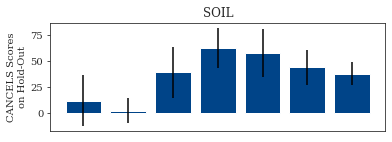

In [89]:
compare_plot_avg(np.array(soil_maccs), [5, 10, 20, 30, 50, 75, 90], which='SOIL')

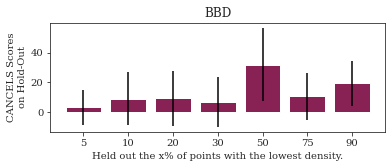

In [90]:
compare_plot_avg(np.array(bbd_maccs), [5, 10, 20, 30, 50, 75, 90], which='BBD')

# Are fungicides structurally different?

In [94]:
DF_AGRO[(DF_AGRO['fungicide'] == 1) & (DF_AGRO['canCalcMACCS'])]

,PUBCHEM_COMPOUND_CID,PUBCHEM_COMPOUND_CANONICALIZED,PUBCHEM_CACTVS_COMPLEXITY,PUBCHEM_CACTVS_HBOND_ACCEPTOR,PUBCHEM_CACTVS_HBOND_DONOR,PUBCHEM_CACTVS_ROTATABLE_BOND,PUBCHEM_CACTVS_SUBSKEYS,PUBCHEM_IUPAC_OPENEYE_NAME,PUBCHEM_IUPAC_CAS_NAME,PUBCHEM_IUPAC_NAME_MARKUP,...,urea herbicide,veterinary substance,wood preservative,isInSOIL,isInBBD,SOIL_top50,BBD_top50,SOIL_top20,BBD_top20,canCalcMACCS
9,243,1,104.0,2,1,1,AAADcYBgMAAAAAAAAAAAAAAAAAAAAAAAAAAwAAAAAAAAAA...,benzoic acid,benzoic acid,benzoic acid,...,0,0,0,True,False,0.0,0.0,0.0,0.0,True
20,712,1,2.0,1,0,0,AAADcQAAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,formaldehyde,formaldehyde,formaldehyde,...,0,0,0,True,True,0.0,0.0,0.0,0.0,True
34,980,1,123.0,3,1,0,AAADcYBiMAAAAAAAAAAAAAAAAAAAAAAAAAAwAAAAAAAAAA...,4-nitrophenol,4-nitrophenol,4-nitrophenol,...,0,0,0,False,True,0.0,0.0,0.0,0.0,True
38,1004,1,49.8,4,3,0,AAADcQAAOAIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,phosphoric acid,phosphoric acid,phosphoric acid,...,0,0,0,True,False,0.0,0.0,0.0,0.0,True
41,1032,1,40.2,2,1,1,AAADcYBAMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,propionic acid,propanoic acid,propanoic acid,...,0,0,0,False,False,0.0,0.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348,135424353,1,316.0,2,1,4,AAADceBzIAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAAA...,5-butyl-2-(dimethylamino)-4-methyl-1H-pyrimidi...,5-butyl-2-(dimethylamino)-4-methyl-1H-pyrimidi...,5-butyl-2-(dimethylamino)-4-methyl-1<I>H</I>-p...,...,0,0,0,False,False,0.0,0.0,0.0,0.0,True
2349,135424354,1,305.0,2,2,5,AAADceBzIAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAAAAAAAA...,5-butyl-2-(ethylamino)-4-methyl-1H-pyrimidin-6...,5-butyl-2-(ethylamino)-4-methyl-1H-pyrimidin-6...,5-butyl-2-(ethylamino)-4-methyl-1<I>H</I>-pyri...,...,0,0,0,True,False,0.0,0.0,0.0,0.0,True
2365,135515530,1,588.0,8,1,7,AAADceB7McAAAAAAAAAAAAAAGAAAAAAAAAAwYAAAAAAAAA...,"N-[(Z)-N-(cyclopropylmethoxy)-C-[2,3-difluoro-...","N-[(Z)-cyclopropylmethoxyimino-[2,3-difluoro-6...",<I>N</I>-[(<I>Z</I>)-<I>N</I>-(cyclopropylmeth...,...,0,0,0,True,False,0.0,0.0,0.0,0.0,True
2395,137968074,1,1020.0,23,16,9,AAADcfB7vgBgAAAAAAAAAAAAAAAAASAAAAA0QAAAAAAAAA...,"2-[(1S,2R,3R,4S,5R,6R)-2-[(2R,3R,4R,5S)-3-[(2S...","2-[(1R,2R,3S,4R,5R,6S)-3-(diaminomethylideneam...","2-[(1<I>R</I>,2<I>R</I>,3<I>S</I>,4<I>R</I>,5<...",...,0,0,0,False,False,0.0,0.0,0.0,0.0,True
